This script is used to produce Figure 4 (changes in bloom start and end and daily NPP at individual locations) for the Payne et al. paper "End-of-century Arctic Ocean phytoplankton blooms start a month earlier due to anthropogenic climate change".

1. Import packages

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import glob
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import math
import matplotlib.path as mpath
import xesmf as xe

2. Read in a randomly chosen NPP file. This is used to generate latitude (lat) and longitude (lon) fields for CESM files.

In [2]:
vdir = 'ocn' # 'ocn' or 'ice'
vnam = 'photoC_diat_zint_2'#, 'photoC_diaz_zint', 'photoC_sp_zint']#,'photoC_diaz_zint','photoC_sp_zint'] # 'aice' # 'SST'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam + '/'

fnam = 'b.e21.BSSP370cmip6.f09_g17.LE2-1301.003.pop.h.ecosys.nday1.photoC_diat_zint_2.20450102-20550101.nc'

ncfile = xr.open_dataset(fdir + fnam)
lon = ncfile.TLONG.values
lat = ncfile.TLAT.values

ok = ~np.isnan(lon)
xp = ok.ravel().nonzero()[0]
fp = lon[~np.isnan(lon)]
x  = np.isnan(lon).ravel().nonzero()[0]
lon[np.isnan(lon)] = np.interp(x, xp, fp)

ok = ~np.isnan(lat)
xp = ok.ravel().nonzero()[0]
fp = lat[~np.isnan(lat)]
x  = np.isnan(lat).ravel().nonzero()[0]
lat[np.isnan(lat)] = np.interp(x, xp, fp)


3. Make the areacello_ocn array that gives the area (in m2) of each grid cell in the larger region (latitude > 50°N).

In [3]:
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
areacello_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(ncfile['photoC_diat_zint_2'][180,i,j]) == False and ncfile["TLAT"][i,j] > 50:
            areacello_ocn[i,j] = areacello[i,j]


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


4. Read in bloom start (max_25) and end (max_25_2) files and npp during the bloom (npp_bloom) and total annual npp (npp_tot). These files were created for each year and across all ensemble members using the "BloomMetrics" script. Bloom start occurs on the date when biomass first surpasses 25% of the maximum biomass at any given grid cell, and end occurs on the date when biomass first diminishes below 25% of the maximum following the peak in biomass. I then set any zero values to 'nan'.

In [4]:
max_25 = np.zeros([14,384,320,50]); max_100 = np.zeros([14,384,320,50]); max_25_2 = np.zeros([14,384,320,50]); 
npp_tot = np.zeros([14,384,320,50]); npp_bloom = np.zeros([14,384,320,50]); 
for yrset in np.arange(0,14):
    yrnum = str(1970 + yrset*10)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_25.txt")
    max_25[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_25_2.txt")
    max_25_2[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_npp_bloom.txt")
    npp_bloom[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_npp_tot.txt")
    npp_tot[yrset,:,:,:] = dir.reshape(384,320,50)


In [5]:
max_25 = np.where(max_25==0, np.nan, max_25)
max_100 = np.where(max_100==0, np.nan, max_100)
max_25_2 = np.where(max_25_2==0, np.nan, max_25_2)
npp_bloom = np.where(npp_bloom==0, np.nan, npp_bloom)
npp_tot = np.where(npp_tot==0, np.nan, npp_tot)

5. Here, I read in the sea ice mask and then I regrid the sea ice files to an even grid, which allows me to plot them as contours on the bloom importance maps below.

In [6]:
# a. Read in a shapefile of the sea ice masks (perennial ice, seasonal ice, open water)
ds_simask = xr.open_dataset('/glade/u/home/cpayne/Projects/BloomLength/Input/simask.nc')
si_clim = ds_simask["si_clim"]
si_ens = ds_simask["si_ens"]

# load the xarray lat/lon files from pop grid
TLONG = ncfile.TLONG
TLAT = ncfile.TLAT

# Rename TLON and TLAT coordinates to be lon and lat so we can join them with sea ice data
TLONG = TLONG.rename({'nlon':'lon','nlat':'lat'})
TLAT =  TLAT.rename({'nlon':'lon','nlat':'lat'})

# reset sea ice lat/lon coordinates since TLON looks weird (above)
si_clim['TLON'] = TLONG
si_clim['TLAT'] = TLAT

si_ens['TLON'] = TLONG
si_ens['TLAT'] = TLAT

#Now rename TLON and TLAT coordinates to be lon and lat because regridders needs that specific naming
si_clim = si_clim.rename({'TLON':'lon','TLAT':'lat'})
si_ens = si_ens.rename({'TLON':'lon','TLAT':'lat'})

In [7]:
# Setting up a target grid 
# Do not include 90N and 90S otherwise cartopy gets rage-y (i.e. it doesn't work) when plotting
lat_new = np.arange(-89.5,90.0,0.5) 
lon_new = np.arange(0.0,361.0,1.0)

#create a meshgrid (2D fields of lats and lons)
lon2d,lat2d=np.meshgrid(lon_new,lat_new) 
#set up the target grid as an xarray Dataset
target_grid=xr.Dataset({'lat': (['y', 'x'], lat2d),'lon': (['y', 'x'], lon2d)})

#input grid, output grid, method, keyword arguments
regridder = xe.Regridder(si_clim, target_grid, 'nearest_s2d',periodic=True,reuse_weights=False)

# actually do the regridding
si_clim_regrid = regridder(si_clim)
si_ens_regrid = regridder(si_ens)

6. Here, I choose the data I want to plot across the Arctic. I use 'yr2' to control the year I compare to 1970 (=0) and 'vari' and 'vari2' to control which variable I analyze. Bloom start = max_25, bloom end = max_25_2, and bloom length = max_25_2 - max_25. I exclude data where the t-test reveals that the p value is >0.05, indicating an statistically insignificant difference in the variable between the two years.

In [12]:
yr2 = 13 # 5 = 2020, 8 = 2050, 13 = 2100
data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)
vari = max_25_2[0,:,:,:]-max_25[0,:,:,:]
vari2 = max_25_2[yr2,:,:,:]-max_25[yr2,:,:,:]
varichange = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            ttest = stats.ttest_rel(vari[i,j,:], vari2[i,j,:])
            if ttest.pvalue < 0.05:
                varichange[i,j] = np.nanmean(vari2[i,j,:]) - np.nanmean(vari[i,j,:])

/glade/derecho/scratch/cpayne/tmp/ipykernel_62695/3211699889.py:2: RuntimeWarning: Mean of empty slice
  data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
/glade/derecho/scratch/cpayne/tmp/ipykernel_62695/3211699889.py:3: RuntimeWarning: Mean of empty slice
  data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)


7. Here I plot Fig 4A

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  result = super().contourf(*args, **kwargs)


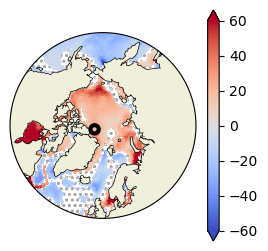

In [18]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# set figure basics (size, projection)
fig = plt.figure(figsize=(3,3)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());

# make the background stippled throughout the region
plt.rcParams['hatch.color'] = 'darkgray'
ax.contourf(lon, lat, areacello,
            transform=ccrs.PlateCarree(),
            colors='none', edgecolor = 'grey',
            # levels = [.9,1.1],
            zorder = 0,
            hatches=['...'])

# plot changes in the actual variable of interest on top
pc = ax.pcolormesh(lon, lat, varichange, 
                   transform=ccrs.PlateCarree(), vmin = -60, vmax = 60, cmap='coolwarm', zorder = 1);

# plot points of interest (locations of data used in Figures 4C-F.
plt.scatter(189,72.5,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Chukchi
plt.scatter(275.6,58.9,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Hudson
plt.scatter(181.2,60.95,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Bering
plt.scatter(289.4,85.9,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =3) #Central Arctic

# add land and colorbar
ax.coastlines();  ax.add_feature(cfeature.LAND,zorder=2); #plt.colorbar(pc, orientation='horizontal', extend='both');
plt.colorbar(pc, orientation='vertical', extend='both');

# write out figure
# figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig4a.png';
figdir = '/glade/u/home/cpayne/Projects/BloomLength/PresentationFigs/Central.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()


8. Here, I choose the data I want to plot across the Arctic by comparing changes in standard deviation. I use 'yr2' to control the year I compare to 1970 (=0) and 'vari' and 'vari2' to control which variable I analyze. Bloom start = max_25, bloom end = max_25_2, and bloom length = max_25_2 - max_25.

In [13]:
yr2 = 13 # 5 = 2020, 8 = 2050, 13 = 2100
data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)
vari = max_25_2[0,:,:,:]-max_25[0,:,:,:]
vari2 = max_25_2[yr2,:,:,:]-max_25[yr2,:,:,:]
varichange = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            ttest = stats.ttest_rel(vari[i,j,:], vari2[i,j,:])
            if ttest.pvalue < 0.05:
                varichange[i,j] = np.nanstd(vari2[i,j,:]) - np.nanstd(vari[i,j,:])

/glade/derecho/scratch/cpayne/tmp/ipykernel_9854/3618265880.py:2: RuntimeWarning: Mean of empty slice
  data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
/glade/derecho/scratch/cpayne/tmp/ipykernel_9854/3618265880.py:3: RuntimeWarning: Mean of empty slice
  data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)


9. Here, I plot Figure 4B.

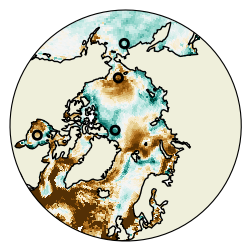

In [14]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# set figure basics (size, projection)
fig = plt.figure(figsize=(3,3)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());

# plot changes in the actual variable of interest on top
pc = ax.pcolormesh(lon, lat, np.std(vari2,axis=2) - np.std(vari,axis=2), 
                   transform=ccrs.PlateCarree(), vmin = -20, vmax = 20, cmap='BrBG_r');   

# plot points of interest (locations of data used in Figures 4C-F.
plt.scatter(189,72.5,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Chukchi
# plt.scatter(346.1,71.2,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Greenland
plt.scatter(275.6,58.9,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Hudson
plt.scatter(181.2,60.95,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Bering
plt.scatter(289.4,85.9,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Central Arctic

# add land on top and colorbar
ax.coastlines();  ax.add_feature(cfeature.LAND); #plt.colorbar(pc, orientation='horizontal', extend='both');

# print this figure
figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig4b.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# # plt.close()

10. Read in 1970, 2020, and 2100 daily NPP data (these steps takes a while)

In [8]:
## a. Select variable of interest and locate the files
vdir = 'ocn' # 'ocn' or 'ice'
vnam = ['photoC_diat_zint_2','photoC_diaz_zint_2','photoC_sp_zint_2']#['diatC_zint_100m', 'diazC_zint_100m', 'spC_zint_100m']# # 'aice' # 'SST'
npp_clim1970 = np.full([50, 365, 384, 320], np.nan)
for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*19700102*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values
        lon, lat = ncfile.TLONG.values, ncfile.TLAT.values #if in 'ice', use 'TLON', in 'ocn', use 'TLONG'

# e. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)
# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,365):
                npp_clim1970[i,t,:,:] = dat[t,:,:]#[t+1825,:,:] #Get the year that is 5 years in (e.g. 2050)
        else:
            for t in range(0,365):
                npp_clim1970[i,t,:,:] = dat[t,:,:] + npp_clim1970[i,t,:,:]#dat[t+1825,:,:] + dat_clim[i,t,:,:] #Get the year that is 5 years in (e.g. 2050)
 

/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_diat_zint_2/b.e21.BHISTsmbb.f09_g17.LE2-1231.018.pop.h.ecosys.nday1.photoC_diat_zint_2.19700102-19800101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_diaz_zint_2/b.e21.BHISTsmbb.f09_g17.LE2-1301.016.pop.h.ecosys.nday1.photoC_diaz_zint_2.19700102-19800101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_sp_zint_2/b.e21.BHISTsmbb.f09_g17.LE2-1251.019.pop.h.ecosys.nday1.photoC_sp_zint_2.19700102-19800101.nc


In [10]:
## a. Select variable of interest and locate the files
vdir = 'ocn' # 'ocn' or 'ice'
vnam = ['photoC_diat_zint_2','photoC_diaz_zint_2','photoC_sp_zint_2']#['diatC_zint_100m', 'diazC_zint_100m', 'spC_zint_100m']# # 'aice' # 'SST'
npp_clim2020 = np.full([50, 365, 384, 320], np.nan)
for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*20150101*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values
        lon, lat = ncfile.TLONG.values, ncfile.TLAT.values #if in 'ice', use 'TLON', in 'ocn', use 'TLONG'

# e. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)
# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,365):
                npp_clim2020[i,t,:,:] = dat[t+1825,:,:]#[t+1825,:,:] #Get the year that is 5 years in (e.g. 2050)
            #dat_diat[i,:,:] = np.nansum(dat[1825:3650,:,:], axis = 0)
        else:
            for t in range(0,365):
                npp_clim2020[i,t,:,:] = dat[t+1825,:,:] + npp_clim2020[i,t,:,:]#dat[t+1825,:,:] + dat_clim[i,t,:,:] #Get the year that is 5 years in (e.g. 2050)
 

/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_diat_zint_2/b.e21.BSSP370smbb.f09_g17.LE2-1301.011.pop.h.ecosys.nday1.photoC_diat_zint_2.20150101-20250101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_diaz_zint_2/b.e21.BSSP370smbb.f09_g17.LE2-1281.016.pop.h.ecosys.nday1.photoC_diaz_zint_2.20150101-20250101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_sp_zint_2/b.e21.BSSP370smbb.f09_g17.LE2-1251.020.pop.h.ecosys.nday1.photoC_sp_zint_2.20150101-20250101.nc


In [9]:
## a. Select variable of interest and locate the files
vdir = 'ocn' # 'ocn' or 'ice'
vnam = ['photoC_diat_zint_2','photoC_diaz_zint_2','photoC_sp_zint_2']#['diatC_zint_100m', 'diazC_zint_100m', 'spC_zint_100m']# # 'aice' # 'SST'
npp_clim2100 = np.full([50, 365, 384, 320], np.nan)
for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*20950102*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values
        lon, lat = ncfile.TLONG.values, ncfile.TLAT.values #if in 'ice', use 'TLON', in 'ocn', use 'TLONG'

# e. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)
# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,365):
                npp_clim2100[i,t,:,:] = dat[t+1825,:,:]#[t+1825,:,:] #Get the year that is 5 years in (e.g. 2050)
            #dat_diat[i,:,:] = np.nansum(dat[1825:3650,:,:], axis = 0)
        else:
            for t in range(0,365):
                npp_clim2100[i,t,:,:] = dat[t+1825,:,:] + npp_clim2100[i,t,:,:]#dat[t+1825,:,:] + dat_clim[i,t,:,:] #Get the year that is 5 years in (e.g. 2050)
 

/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_diat_zint_2/b.e21.BSSP370smbb.f09_g17.LE2-1281.012.pop.h.ecosys.nday1.photoC_diat_zint_2.20950102-21001231.nc
/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_diaz_zint_2/b.e21.BSSP370smbb.f09_g17.LE2-1251.018.pop.h.ecosys.nday1.photoC_diaz_zint_2.20950102-21001231.nc
/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_sp_zint_2/b.e21.BSSP370smbb.f09_g17.LE2-1011.001.pop.h.ecosys.nday1.photoC_sp_zint_2.20950102-21001231.nc


11. Make Figures 4C-F. To do this, copy lines of code from the cell directly below here into the appropriate spots.

Bering: 
i = 322; j=193; maxvl = .33; 
plt.yticks([0,0.05,0.1,0.15,0.2,y1970,y2020,y2100], labels = [0,0.05,0.1,0.15,0.2,1970,2020,2100])
Chukchi:
i = 342; j=194; maxvl = .082; 
plt.yticks([0,0.01,0.02,0.03,0.04,0.05,y1970,y2020,y2100], labels = [0,0.01,0.02,0.03,0.04,0.05,1970,2020,2100])
Hudson: 
i = 341; j=275; maxvl = .057; 
plt.yticks([0,0.01,0.02,0.03,0.04,y1970,y2020,y2100], labels = [0,0.01,0.02,0.03,0.04,1970,2020,2100])
Central: 
i = 372; j=176; maxvl = .064; 
plt.yticks([0,0.01,0.02,0.03,0.04,y1970,y2020,y2100], labels = [0,0.01,0.02,0.03,0.04,1970,2020,2100])
Greenland: 
i = 373; j = 40; maxvl = .175
plt.yticks([0,0.04,0.08,0.12,y1970,y2020,y2100], labels = [0,0.04,0.08,0.12,1970,2020,2100])


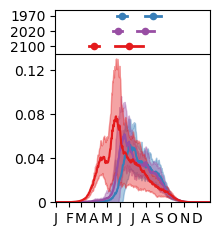

In [17]:
# Copy first line of code for desired point here.
i = 373; j = 40; maxvl = .175

# Set height of bloom metrics data and colors for the plot
y1970 = .97*maxvl; y2020 = .89*maxvl; y2100 = .81*maxvl; ln = .77*maxvl
rd = '#e41a1c'; pr = '#984ea3'; bl = '#377eb8'

# Calculate daily NPP mean and St. Dev. for 1970, 2020, and 2100.
mean_1970 = np.mean(npp_clim1970[:,:,i,j],axis=0); sd_1970 = np.std(npp_clim1970[:,:,i,j],axis=0)
mean_2020 = np.mean(npp_clim2020[:,:,i,j],axis=0); sd_2020 = np.std(npp_clim2020[:,:,i,j],axis=0)
mean_2100 = np.mean(npp_clim2100[:,:,i,j],axis=0); sd_2100 = np.std(npp_clim2100[:,:,i,j],axis=0)

# Calculate mean and St. Dev. bloom start and end timing for 1970, 2020, and 2100
meanstart_1970 = np.mean(max_25[0,i,j,:]); stdstart_1970 = np.std(max_25[0,i,j,:])
meanend_1970 = np.mean(max_25_2[0,i,j,:]); stdend_1970 = np.std(max_25_2[0,i,j,:])
meanstart_2020 = np.mean(max_25[5,i,j,:]); stdstart_2020 = np.std(max_25[5,i,j,:])
meanend_2020 = np.mean(max_25_2[5,i,j,:]); stdend_2020 = np.std(max_25_2[5,i,j,:])
meanstart_2100 = np.mean(max_25[13,i,j,:]); stdstart_2100 = np.std(max_25[13,i,j,:])
meanend_2100 = np.mean(max_25_2[13,i,j,:]); stdend_2100 = np.std(max_25_2[13,i,j,:])

# Initialize figure
fig = plt.figure(figsize=(2,2.5))

# Plot daily NPP mean and St. Dev. for each year
plt.fill_between(np.arange(1,366),mean_1970 - sd_1970, mean_1970 + sd_1970, 
                 color=bl,alpha=0.4)
plt.plot(np.arange(1,366),mean_1970, color=bl)

plt.fill_between(np.arange(1,366),mean_2020 - sd_2020, mean_2020 + sd_2020, 
                 color=pr,alpha=0.4)
plt.plot(np.arange(1,366),mean_2020, color=pr)

plt.fill_between(np.arange(1,366),mean_2100 - sd_2100, mean_2100 + sd_2100, 
                 color=rd,alpha=0.4)
plt.plot(np.arange(1,366),mean_2100, color=rd)

# Plot bloom start and end timing for each year
plt.plot([meanstart_1970-stdstart_1970,meanstart_1970+stdstart_1970],
         [y1970,y1970],color = bl, linewidth=2)
plt.plot([meanend_1970-stdend_1970,meanend_1970+stdend_1970],
         [y1970,y1970],color = bl, linewidth=2)
plt.scatter(meanstart_1970,y1970,color = bl, s=20)
plt.scatter(meanend_1970,y1970,color = bl, s=20)

plt.plot([meanstart_2020-stdstart_2020,meanstart_2020+stdstart_2020],
         [y2020,y2020],color = pr, linewidth=2)
plt.plot([meanend_2020-stdend_2020,meanend_2020+stdend_2020],
         [y2020,y2020],color = pr, linewidth=2)
plt.scatter(meanstart_2020,y2020,color = pr, s=20)
plt.scatter(meanend_2020,y2020,color = pr, s=20)

plt.plot([meanstart_2100-stdstart_2100,meanstart_2100+stdstart_2100],
         [y2100,y2100],color = rd, linewidth=2)
plt.plot([meanend_2100-stdend_2100,meanend_2100+stdend_2100],
         [y2100,y2100],color = rd, linewidth=2)
plt.scatter(meanstart_2100,y2100,color = rd, s=20)
plt.scatter(meanend_2100,y2100,color = rd, s=20)

# Set axis limits
plt.ylim(-.0001,maxvl); plt.xlim(-1,366)

# Copy second line of code for desired point here.
plt.yticks([0,0.04,0.08,0.12,y1970,y2020,y2100], labels = [0,0.04,0.08,0.12,1970,2020,2100])

# Set x axis labels and make line to separate upper data from lower
plt.xticks([1,32,60,91,121,152,182,213,244,274,305,335], 
           labels = ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.plot([-1,367],[ln,ln],color='k',linewidth=.8)

# write plot out
figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig4g.png';
plt.savefig(figdir,facecolor='none', dpi = 600,bbox_inches="tight");
# plt.close()


12. Print out a ton of information about each point (used in writing the paper.

In [28]:
# i = 322; j = 193; # Bering
# i = 342; j = 194; # Chukchi
# i = 341; j = 275; # Hudson
# i = 372; j = 176; # Central
i = 373; j = 40;  # Greenland

print('Greenland')
print('Sea Ice 1970:', np.mean(si_ens[:,0,i,j]).values)
print('Sea Ice 2020:', np.mean(si_ens[:,5,i,j]).values)
print('Sea Ice 2100:', np.mean(si_ens[:,13,i,j]).values)
# print('Sea Ice 1970:', si_ens[:,0,i,j].values)
# print('Sea Ice 2020:', si_ens[:,5,i,j].values)
# print('Sea Ice 2100:', si_ens[:,13,i,j].values)
print('.')
print('Bloom Start',np.mean(max_25[0,i,j,:],axis=0),np.mean(max_25[5,i,j,:],axis=0),np.mean(max_25[13,i,j,:],axis=0),
     np.mean(max_25[13,i,j,:],axis=0)-np.mean(max_25[0,i,j,:],axis=0))
print(np.std(max_25[0,i,j,:],axis=0),np.std(max_25[5,i,j,:],axis=0),np.std(max_25[13,i,j,:],axis=0))
print(stats.ttest_rel(max_25[0,i,j,:], max_25[5,i,j,:]))
print(stats.ttest_rel(max_25[0,i,j,:], max_25[13,i,j,:]))
print('.')
print('Bloom End',np.mean(max_25_2[0,i,j,:],axis=0),np.mean(max_25_2[5,i,j,:],axis=0),np.mean(max_25_2[13,i,j,:],axis=0),
     np.mean(max_25_2[13,i,j,:],axis=0)-np.mean(max_25_2[0,i,j,:],axis=0))
print(np.std(max_25_2[0,i,j,:],axis=0),np.std(max_25_2[5,i,j,:],axis=0),np.std(max_25_2[13,i,j,:],axis=0))
print(stats.ttest_rel(max_25_2[0,i,j,:], max_25_2[5,i,j,:]))
print(stats.ttest_rel(max_25_2[0,i,j,:], max_25_2[13,i,j,:]))
print('.')
print('Bloom Length',np.mean(max_25_2[0,i,j,:]-max_25[0,i,j,:],axis=0),np.mean(max_25_2[5,i,j,:]-max_25[5,i,j,:],axis=0),np.mean(max_25_2[13,i,j,:]-max_25[13,i,j,:],axis=0),
     np.mean(max_25_2[13,i,j,:]-max_25[13,i,j,:],axis=0)-np.mean(max_25_2[0,i,j,:]-max_25[0,i,j,:],axis=0))
print(np.std(max_25_2[0,i,j,:]-max_25[13,i,j,:],axis=0),np.std(max_25_2[13,i,j,:]-max_25[0,i,j,:],axis=0))
print(stats.ttest_rel(max_25_2[0,i,j,:]-max_25[0,i,j,:], max_25_2[5,i,j,:]-max_25[5,i,j,:]))
print(stats.ttest_rel(max_25_2[0,i,j,:]-max_25[0,i,j,:], max_25_2[13,i,j,:]-max_25[13,i,j,:]))
print('.')
print('Bloom NPP',np.mean(npp_bloom[0,i,j,:],axis=0),np.mean(npp_bloom[5,i,j,:],axis=0),np.mean(npp_bloom[13,i,j,:],axis=0))
print(np.std(npp_bloom[0,i,j,:],axis=0),np.std(npp_bloom[5,i,j,:],axis=0),np.std(npp_bloom[13,i,j,:],axis=0))
print(stats.ttest_rel(npp_bloom[0,i,j,:],npp_bloom[5,i,j,:]))
print(stats.ttest_rel(npp_bloom[0,i,j,:],npp_bloom[13,i,j,:]))
print('.')
print('Daily Bloom NPP',np.mean(npp_bloom[0,i,j,:]/(max_25_2[0,i,j,:]-max_25[0,i,j,:]),axis=0),
                                np.mean(npp_bloom[5,i,j,:]/(max_25_2[5,i,j,:]-max_25[5,i,j,:]),axis=0),
                                np.mean(npp_bloom[13,i,j,:]/(max_25_2[13,i,j,:]-max_25[13,i,j,:]),axis=0))
print(np.std(npp_bloom[0,i,j,:]/(max_25_2[0,i,j,:]-max_25[0,i,j,:]),axis=0),np.std(npp_bloom[5,i,j,:]/(max_25_2[5,i,j,:]-max_25[5,i,j,:]),axis=0),
      np.std(npp_bloom[13,i,j,:]/(max_25_2[13,i,j,:]-max_25[13,i,j,:]),axis=0))
print(stats.ttest_rel(npp_bloom[0,i,j,:]/(max_25_2[0,i,j,:]-max_25[0,i,j,:]),npp_bloom[5,i,j,:]/(max_25_2[5,i,j,:]-max_25[5,i,j,:])))
print(stats.ttest_rel(npp_bloom[0,i,j,:]/(max_25_2[0,i,j,:]-max_25[0,i,j,:]),npp_bloom[13,i,j,:]/(max_25_2[13,i,j,:]-max_25[13,i,j,:])))
print('.')
print('Tot NPP',np.mean(npp_tot[0,i,j,:],axis=0),np.mean(npp_tot[5,i,j,:],axis=0),np.mean(npp_tot[13,i,j,:],axis=0))
print(np.std(npp_tot[0,i,j,:],axis=0),np.std(npp_tot[5,i,j,:],axis=0),np.std(npp_tot[13,i,j,:],axis=0))
print(stats.ttest_rel(npp_tot[0,i,j,:],npp_tot[5,i,j,:]))
print(stats.ttest_rel(npp_tot[0,i,j,:],npp_tot[13,i,j,:]))
print('.')
print('Prop. Bloom NPP',np.mean(npp_bloom[0,i,j,:]/npp_tot[0,i,j,:],axis=0),np.mean(npp_bloom[5,i,j,:]/npp_tot[5,i,j,:],axis=0),
      np.mean(npp_bloom[13,i,j,:]/npp_tot[13,i,j,:],axis=0))
print(np.std(npp_bloom[0,i,j,:]/npp_tot[0,i,j,:],axis=0),np.std(npp_bloom[5,i,j,:]/npp_tot[5,i,j,:],axis=0),np.std(npp_bloom[13,i,j,:]/npp_tot[13,i,j,:],axis=0))
print(stats.ttest_rel(npp_bloom[0,i,j,:]/npp_tot[0,i,j,:],npp_bloom[5,i,j,:]/npp_tot[5,i,j,:]))
print(stats.ttest_rel(npp_bloom[0,i,j,:]/npp_tot[0,i,j,:],npp_bloom[13,i,j,:]/npp_tot[13,i,j,:]))


Greenland
Sea Ice 1970: 1.0
Sea Ice 2020: 1.0
Sea Ice 2100: 0.14
.
Bloom Start 157.58 146.86 90.96 -66.62000000000002
12.510939213344455 10.469020966642487 12.486728955174769
TtestResult(statistic=5.1723244218088205, pvalue=4.2728531363916795e-06, df=49)
TtestResult(statistic=24.716123308668116, pvalue=2.5322330744397257e-29, df=49)
.
Bloom End 231.04 212.56 172.7 -58.34
19.347309890524834 19.58587245950509 32.99166561421233
TtestResult(statistic=5.0133148518373725, pvalue=7.3906262215337664e-06, df=49)
TtestResult(statistic=10.164921648115378, pvalue=1.1663322805198425e-13, df=49)
.
Bloom Length 73.46 65.7 81.74 8.280000000000001
23.81498687801444 33.506799309990804
TtestResult(statistic=2.4132394890203086, pvalue=0.019596379383371616, df=49)
TtestResult(statistic=-1.412565880245038, pvalue=0.1641036790736959, df=49)
.
Bloom NPP 29.073962470004943 28.275836631002367 36.38982795852874
8.655010455480694 7.947148974348413 22.050267928078156
TtestResult(statistic=0.4685218196150492, pvalu